# Importy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import decimal
import scipy.stats as stats

In [2]:
def drawdemp(random_sample, sub=None, title=None,  xlim_min=None, xlim_max=None, line_style=""):
    """Draws CDF for the given random_sample."""
    xs = np.array(random_sample, dtype=np.float)
    xs.sort()
    step = (xs[-1] - xs[0]) / xs.size
    xs = np.insert(xs, 0, xs[0] - step)
    xs = np.insert(xs, xs.size, xs[-1] + step)
    ys = np.linspace(0, 1, xs.size - 1)

    fig, ax = plt.subplots()
    ax.hlines(y=ys, xmin=xs[:-1], xmax=xs[1:])
    ax.vlines(x=xs[1:-1], ymin=ys[:-1], ymax=ys[1:], linestyle='dashed')
    ax.set_xlim(min(xs), max(xs))
    plt.xlabel("x")
    plt.ylabel("F(x)")
    if xlim_min:
        ax.set_xlim(xlim_min, max(xs))
    if xlim_max:
        ax.set_xlim(min(xs), xlim_max)
    if xlim_min and xlim_max:
        ax.set_xlim(xlim_min, xlim_max)
    if sub:
        plt.plot(xs, [sub(i) for i in xs], line_style)
    if title:
        plt.title(title)
    plt.show()

def finv(f, dx=0.01, ys=None):
    """Inverse function"""
    a = -1
    b = 1
    while float(f(a)) > dx:
        a *= 2
    while f(b) < 1 - dx:
        b *= 2
    xs = np.arange(a, b, dx)
    if not ys:
        ys = np.arange(0, 1, dx)
    dic = {}
    for y in ys:
        T = [x for x in xs if f(x) > y]
        dic[y] = min(T, default=b)
    return dic, list(dic.keys()), list(dic.values())
    

def drawqq(X, distr, title=None):
    """Draws QQ-Plot"""
    X.sort()
    N = len(X)
    q_dic, x, y = finv(distr, dx=1 / N)
    plt.scatter(y, X)
    plt.plot(X, X)
    if title:
        plt.title(title)
    plt.show()

# Generator liczb pseudolosowych

Do generowania liczb pseudolosowych użyjemy metody liniowego generatora kongurentnego, opracowanej przez Lehmer'a w 1951. Polega ona na rekurencyjnym obliczaniu kolejnych liczb pseudolosowych z zakresu od $0$ do $m$ za pomocą poniższego wzoru:
$$
x_i = (c \cdot x_{i-1} + 1)\mod m.
$$
Aby generować liczby całkowite z przedziału $[a, b]$, gdzie $a,b \in \mathbb{Z}$, generujemy $x_i$ według poprzedniego wzoru, a następnie bierzemy
$$x_i\mod(b + 1 - a) + a.$$
Liczby zmiennoprzecinkowe z $U(a,b)$ otrzymujemy następująco:
$$\frac{x_i}{m} \cdot(b - a) + a,$$ w ten sposób można też otrzymać liczby całkowite, wystarczy je zaokrąglić. Właśnie tak postępujemy w przypadku, gdy  $b-a=1$, ponieważ korzystając z pierwszego sposobu uzyskałyśmy niezadowalające wyniki.

In [3]:
class RandomGen:
    def __init__(self, c=21*2**30+3, m=2**38, seed=int((time.time()%1)*10**16)):
        self.c = decimal.Decimal(c)
        self.m = decimal.Decimal(m)
        self.seed = decimal.Decimal(seed)
    
    def change_seed(self, val):
        """Sets seed value equat to val. """
        val = decimal.Decimal(float(val))
        self.seed = val

    def random_seed(self):
        """Sets value of seed equat to random number."""
        val = int((time.time()%1)*10**16)
        self.change_seed(val)

    def random_int(self, n=1, a=0, b=1):
        """Linear congruential generator returns list of n pseudo random numbers(int) from [a, b].
        a and be should be integers."""
        a = decimal.Decimal(int(a))
        b = decimal.Decimal(int(b))
        l = np.zeros(n, dtype = np.int64)
        for i in range(n):
            x_i = (self.c * self.seed + 1) % self.m
            if b - a == 1:
                l[i] = (x_i / self.m + a).quantize(0)
            else:
                l[i] = x_i % (b + 1 - a) + a
            self.change_seed(x_i)
        if n==1:
            return l[0]
        return l

    def random_float(self, n=1, a=0, b=1, prec=28, to_float=True):
        """Linear congruential generator. Returns float number from U(a,b), where a < b,
        or array of n floats with precision prec, by default 28 (cannot be too small). 
        By default returns float64 but if to_float is False returns Decimal objects. """
        decimal.getcontext().prec = prec
        a = decimal.Decimal(a)
        b = decimal.Decimal(b)
        l = np.zeros(n, dtype=np.float64)
        if not to_float:
            l = np.zeros(n, dtype=np.dtype(decimal.Decimal))
        for i in range(n):
            x_i = (self.c * self.seed + 1) % self.m
            l[i] = x_i / self.m * (b - a) + a
            self.change_seed(x_i)
        if n==1:
            return l[0]
        return l

    def random_float_union(self, n=1, prec=28, a=2**64-1, b=2**64, same_prec=True):
        """Returns list of n pseudo random numbers (Decimal objects) 
        from U((0, 1)U(a, b)). Prec means number of digits after comma, 
        by default 28(cannot be too small). If same_prec is True all numbers 
        have the same number of digits after coma."""
        l = np.zeros(n, dtype=np.dtype(decimal.Decimal))
        dp = 0
        if same_prec:
            s = str(self.random_float(a=a, b=b, prec=prec, to_float=False))
            k = s.index('.')
            dp = len(str(self.random_float(prec=prec, to_float=False))) - 1 - len(s[k:])
        for i in range(n):
            U = self.random_float()
            if U < 0.5:
                l[i] = self.random_float(prec=prec, to_float=False)
            else:
                l[i] = self.random_float(a=a, b=b, prec=prec+dp, to_float=False)
        if n==1:
            return l[0]
        return l

    def random_poisson(self, l=1):
        i = 0
        p = np.exp(-l)
        F = p
        U = self.random_float()
        while U > F:
            p  = p * l/(i+1)
            F += p
            i += 1
        return i

    def exp_gen(self, n, l):
        U = self.random_float(n) 
        return -np.log(U)/l

R = RandomGen()

W naszym generatorze domyśle współczynniki wynoszą odpowiednio:
$$c = 21\cdot2^{30} + 3,$$ $$m = 2^{38}.$$

Dla tych wartości okres generatora wynosi ponad 10 milionów.

In [4]:
def period(R, n):
    l = R.random_int(n, b=R.m)
    unique, counts = np.unique(l, return_counts=True)
    T = np.where(counts>=2)[0]
    if T.size > 0:
        return np.where(l==unique[T[0]])[0][1]
    return n 

In [5]:
period(R,10000000)

10000000

Domyślnie za $x_1$, czyli ziarno, przyjmujemy liczbę sekund, które upłyneły od pierwszego stycznia 1970 roku, a raczej tę liczbę, która znajduje się po przecinku, czyli femto sekundy $[10^{-15}s]$. Jest to tak mała liczba, że uznajemy ją za prawdziwie losową.

In [6]:
print('Aktualne ziarno:',R.seed)

R.random_seed()
print('Aktualne ziarno:',R.seed)
l1 = R.random_int(20, a=5.4, b=6)
print(l1)

R.random_seed()
print('Aktualne ziarno:',R.seed)
l2 = R.random_int(20, a=5, b=6)
print(l2)

Aktualne ziarno: 255841467705
Aktualne ziarno: 2757122516632080
[5 5 6 5 5 5 6 5 6 6 6 6 6 6 6 6 5 6 6 5]
Aktualne ziarno: 2757122516632080
[5 5 6 5 5 5 6 5 6 6 6 6 6 6 6 6 5 6 6 5]


Na poniższych wykresach widać, że nasz generator rzeczywiście zwraca liczby z rozkładu jednostajnego oraz, że jest odpowiednio losowy.

**Rozkład dyskretny**

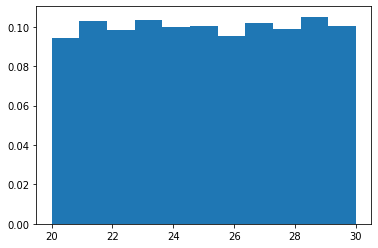

Średnia próbkowa 25.0271
Średnia teoretyczna 25.0


In [7]:
l2 = R.random_int(10000,a=20, b=30)
plt.hist(l2, bins=11, density=True)
plt.show() 
print("Średnia próbkowa", np.mean(l2))
print("Średnia teoretyczna", (30+20)/2)

**Rozkład ciągły (dla względnie małych $a$ i $b$)**

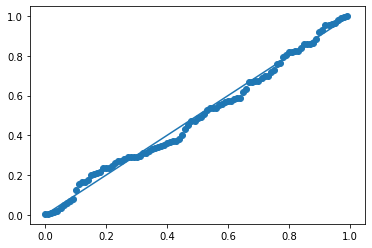

In [9]:
l3 = R.random_float(n=100)
drawqq(l3, stats.uniform.cdf)

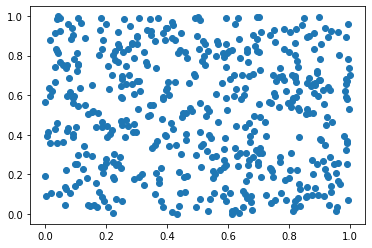

In [11]:
l3 = R.random_float(n=500)
plt.scatter(l3[:-1], l3[1:])
plt.show()

Testy Kołmogorowa-Smirnowa również wypadają dobrze.

In [12]:
alfa = 0.05
result = np.zeros(100)
for i in range(100):
    l_i = R.random_float(n=1000, to_float=True)
    result[i] = stats.kstest(l_i, stats.uniform.cdf).pvalue > alfa
print("Test zgodnosci Kołmogorowa-Smirnowa:", sum(result))

Test zgodnosci Kołmogorowa-Smirnowa: 98.0


Średnia i wariancja też są bliskie teoretycznych wartości.

In [13]:
print("Średnia próbkowa", np.mean(l3))
print("Średnia teoretyczna", 1/2)

print("Wariancia próbkowa", np.var(l3))
print("Wariancja teoretyczna", 1/12)

Średnia próbkowa 0.5114087880259758
Średnia teoretyczna 0.5
Wariancia próbkowa 0.08546330873317101
Wariancja teoretyczna 0.08333333333333333


(array([ 94.,  91., 108.,  92., 103., 105.,  90.,  92., 116., 109.]),
 array([4019.47879751, 4616.63621495, 5213.79363239, 5810.95104983,
        6408.10846726, 7005.2658847 , 7602.42330214, 8199.58071958,
        8796.73813702, 9393.89555446, 9991.0529719 ]),
 <BarContainer object of 10 artists>)

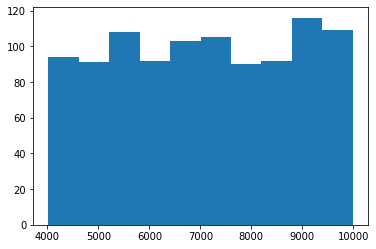

In [17]:
l4 = R.random_float(1000, 4000.5, 10000.5)
plt.hist(l4)

<ipython-input-2-99faaea31ad2>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xs = np.array(random_sample, dtype=np.float)


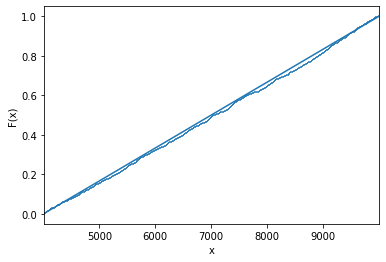

In [18]:
drawdemp(l4, sub= lambda x: stats.uniform.cdf(x, 4000.5, 6000))

In [20]:
alfa = 0.05
result = np.zeros(100)
for i in range(100):
    l_i = R.random_float(1000, 400.5, 1000.5)
    result[i] = stats.kstest(l_i, lambda x: stats.uniform.cdf(x, 400.5, 600)).pvalue > alfa
print("Test zgodnosci Kołmogorowa-Smirnowa:", sum(result))

Test zgodnosci Kołmogorowa-Smirnowa: 96.0


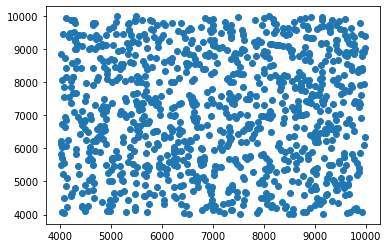

In [21]:
plt.scatter(l4[:-1], l4[1:])

**Rozkład ciągły (dla dużych $a$ i $b$)**

W przypadku bardzo dużych liczb zmiennoprzecinkowych, korzystamy z możliwości pakietu decimal, który daje praktycznie nieograniczoną dokładność nawet dla bardzo dużych floatów.

In [22]:
l5 = R.random_float(1000, 2**64 - 1, 2**64, prec=30, to_float=False)
print(l5[:10])
print()
print("Średnia próbkowa", np.mean(l5))
print("Wariancia próbkowa", np.var(l5))

[Decimal('18446744073709551615.4254116565')
 Decimal('18446744073709551615.0145162196')
 Decimal('18446744073709551615.3404236588')
 Decimal('18446744073709551615.9939272264')
 Decimal('18446744073709551615.9817816792')
 Decimal('18446744073709551615.0273762876')
 Decimal('18446744073709551615.4102538629')
 Decimal('18446744073709551615.2971678387')
 Decimal('18446744073709551615.1727535161')
 Decimal('18446744073709551615.4440417983')]

Średnia próbkowa 18446744073709551615.4872504429
Wariancia próbkowa 0.08337830601239377410473


Metoda random_float_union generuje liczby z rozkładu $U((0,1)\cup(2^{64}-1, 2^{64}))$ i działa w następujący sposób:
1. Losuje liczbę z $U = U(0,1).$
2. Jeśli $U < 0.5$ zwraca liczbę z $U(0,1)$, w przeciwnym przypadku zwraca liczbę z $U(2^{64}-1, 2^{64}).$ 

Gdy same_prec=True wszystkie wylosowane liczby mają tyle samo miejsc po przecinku.

In [23]:
l6_1 = R.random_float_union(n=1000, prec=60 ,same_prec=True)
print(l6_1[0:5])

[Decimal('18446744073709551615.3147063837968744337558746337890625')
 Decimal('18446744073709551615.789388704186421819031238555908203125')
 Decimal('0.03027958769234828650951385498046875')
 Decimal('0.917047539245686493813991546630859375')
 Decimal('18446744073709551615.366709103225730359554290771484375')]


In [24]:
l6_2 = R.random_float_union(n=5, same_prec=False)
print(l6_2)

[Decimal('18446744073709551615.40188378')
 Decimal('18446744073709551615.32398528')
 Decimal('0.5916487340291496366262435913')
 Decimal('0.7193698562768986448645591736')
 Decimal('18446744073709551615.33760996')]


(array([504.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 496.]),
 array([2.51988749e-04, 1.84467441e+18, 3.68934881e+18, 5.53402322e+18,
        7.37869763e+18, 9.22337204e+18, 1.10680464e+19, 1.29127209e+19,
        1.47573953e+19, 1.66020697e+19, 1.84467441e+19]),
 <BarContainer object of 10 artists>)

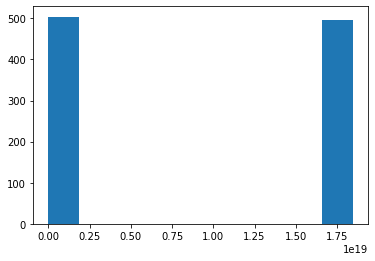

In [25]:
plt.hist(l6_1)

In [ ]:
print("Średnia próbkowa:", np.mean(l6_1))
print("Wariancia próbkowa:", np.var(l6_1))

In [ ]:
l6_3 = R.random_float_union(n=1000, a=2, b=3, same_prec=True)
fig, ax = plt.subplots()
plt.xticks([0,1,1.5,2,3],[0, 1,'$\dots$','$2^{64}-1$', '$2^{64}$'])
plt.yticks([0,1,1.5,2,3],[0, 1,'$\dots$','$2^{64}-1$', '$2^{64}$'])
plt.scatter(l6_3[:-1], l6_3[1:], s=4*2)

Podsumowując, zaimplementowany przez nas generator liczb pseudolosowych wydaje się być dostatecznie losowy, przechodzi testy Kołmogorowa-Smirnowa, ma (dosyć) duży okres oraz losuje liczby z odpowiednich rozkładów. Nie czyni to go jeszcze dobrym generatorem, ale z pewnością generatorem.